# Binary Logistic Regression 

<br>

```{image} images/island_bin_log_reg.png
:class: bg-primary mb-1
:width: 270px
:align: center
```

<br>

Imagine you are visiting another island, this time with a team of team of mental health researchers. There are some problems with addiction on the island, and you're here to investigate a sample of people who frequently use one of two types of psychoactive drug. You collect a random sample of 100 drug users, and your dataset contains the following variables:

`number_of_social_contacts` - a count variable, indicating the number of social contacts that a person has in a week

`drug_alone` - a binary categorical variable, indicating whether a person uses their drug of choice alone at least twice a week (`1 = YES`, `0 = NO`)

`addiction_status` -	a binary categorical variable, indicating whether a person meets the diagnostic criteria for addiction (`1 = ADDICT`, `0 = NOT ADDICT`)

The data is shown below:

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
import islands_GLM
from scipy.optimize import minimize

# make plots look like R
islands_GLM.r_ify()

# generate the data
df = islands_GLM.addiction_data_gen()

# show the data
df

,number_of_social_contacts,drug_alone,addiction_status
0,2,1,0
1,10,0,0
2,11,1,0
3,6,0,0
4,7,1,0
...,...,...,...
95,12,1,0
96,10,1,0
97,16,1,0
98,7,0,0


Firstly, your team will assess the relationship between `number_of_social_contacts` (predictor) and `addiction_status` (outcome). The scatterplot showing these variables is below:

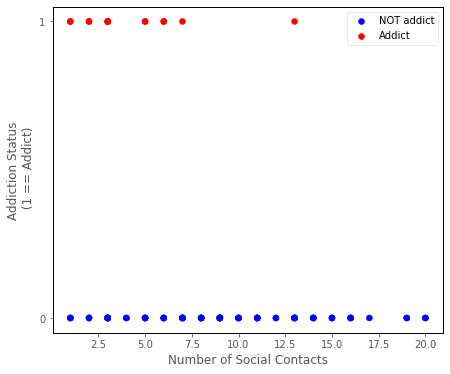

In [2]:
# this code generates the plot below
islands_GLM.addiction_plot(df);

From the scatterplot, it does like like the variables might be associated - it appears that addicts generally have lower numbers of social contacts. 

Because `addiction_status` is a binary categorical variable, most of the models we can fit to predict it will predict the probability of being in the category which is dummy-coded as 1 (in this case ADDICT).

If we fit a linear regression model to this data, we are using a *linear probability model*. The graph below shows the results of using linear regression to predict `addiction_status ~ number_of_social_contacts`:

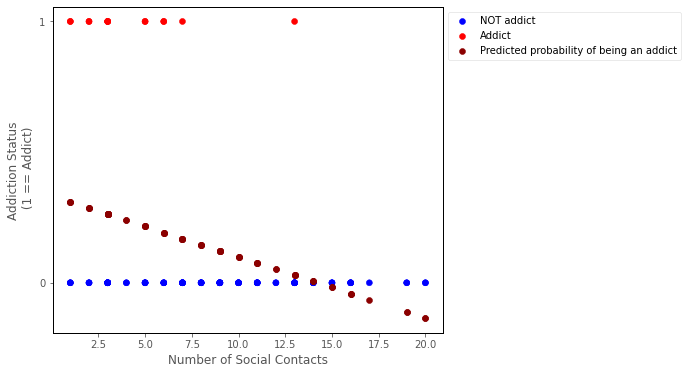

In [3]:
# fit a linear regression model to the data, and plot the model predictions
lin_reg = smf.ols('addiction_status ~ number_of_social_contacts', data = df).fit()
islands_GLM.addiction_plot(df, predictions = lin_reg.params[0] + lin_reg.params[1] * df['number_of_social_contacts'], plot_predictions = True)

The linear regression probability predictions do capture some of the trend in the data - people with a higher number of social contacts do appear to be less likely to be addicts, and this is indicated by the negative slope of the line.

However, linear regression can produce predictions which range from negative to positive infinity, but probabilities are bounded between 0 and 1. We can see from the graph that for sufficiently high values of `number_of_social_contacts` the linear regression model makes negative probability predictions. (NB: negative probabilities do have a meaning in [some contexts](https://stats.stackexchange.com/questions/333610/negative-probabilities-layman-explanations), but generally not in social/life science...).

The cell below uses the slope and intercept from the linear regression model to predict the probability of being an addict, for the largest value of `number_of_social_contacts` in the dataset:

In [4]:
# the prediction from linear regression for the largest value of `number_of_social_contacts`
lin_reg.params[0] + lin_reg.params[1] * np.max(df['number_of_social_contacts'])

-0.13466990684487634

This is the motivation for logistic regression, it produces probability predictions that are bounded between 0 and 1, and overcomes the issue with applying linear regression to this sort of data.

## Context

We can use binary logistic regression when we are predicting a binary categorical variable from one or more predictor variables. As with all generalized linear models, the predictor variables can be of any type (quantitative-continuous, quantitative-discrete, nominal-categorical, ordinal-categorical).

The predictions from binary logistic regression that we are most interested in are the predicted probabilities of being in either outcome category. As we will see, we have to transform the predictions to get them into that form. The graph below shows the classic logistic 'S' shape of the probability predictions of logistic regression, as a function of some predictor:

![](images/binary_log_reg_probability.png)

Let's assume the graph shows the probability of being in the outcome category dummy coded as 1, as the value of the predictor increases. 

For any value of the predictor, we can use the predicted probability of being in outcome category 1 to calculate the predicted probability of being in outcome category 0. We do this by subtracting the predicted probability of being in outcome category 1, from 1.

We could then, for any value of the predictor, create a barplot of the predicted proportion of scores in either category, for a given value of the predictor. Around the middle of the S shaped curve just shown above, such a barplot might look like:

![](images/binary_log_reg_bar.jpg)

This barplot shows the Bernoulli distribution of the outcome categories, for a given level of the predictor. This is how binary logistic regression works from a 'conditional distribution' perspective: it fits a Bernoulli distribution for every value of the predictor:

![](images/binary_log_reg_conditional.png)

## Model

We can denote the predicted probability of being in category 1 with:

$ \large \hat{P}_{(y_{i} = 1)} = \hat\pi_{1i}$ 

And the the predicted probability of being in category 0 with:

$ \large \hat{P}_{(y_{i} = 0)} = 1 - \hat\pi_{1i} $

Or:

$ \large \hat{P}_{(y_{i} = 0)} =\hat\pi_{0i} $

Binary logistic regression uses a *logit* link function and so is sometimes referred to as a logit model. The model fits a line on the log scale, where it predicts the log of the odds ratio $ln \large \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right) $ of being in category 1. The prediction equation for binary logistic regression model is:

$ \large \hat{y}_{i} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_i = b_{0} + b_{i}x_{11} \dots + b_{k}x_{ki} $

The individual prediction ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \large \hat{y}_{1} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_1 = b_{0} + b_{1}x_{11} \dots + b_{k}x_{k1} $$

$$ \large \hat{y}_{2} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_2 = b_{0} + b_{1}x_{12} \dots + b_{k}x_{k2} $$

$$ \large \hat{y}_{3} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_3 = b_{0} + b_{1}x_{13} \dots + b_{k}x_{k3} $$

$$ \dots $$

$$ \large \hat{y}_{n} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_n = b_{0} + b_{1}x_{1n} \dots + b_{k}x_{kn} $$

...where there are $k$ predictor variables, and $n$ observations, and where:

$\hat{y_i} $ : is the predicted log odds of being in category 1, for a given set of predictor scores, for the $i$th observation

$b_0$ : is the intercept term, the predicted value of the outcome variable when all predictors equal 0

$b_1$ : is the slope of the 1st predictor variable

$x_{1i}$ : is the score on the the first predictor variable, for the $i$th observation

$b_k$ : is the slope of the $k$th predictor variable

$x_{ki}$ : is the score on the $k$th predictor variable, for the $i$th observation

In matrix form, the model is:

$$
\Large \begin{bmatrix}
           {\hat{y}_{1}} \\
           {\hat{y}_{2}} \\
           {\hat{y}_{3}} \\
           \vdots \\
           {\hat{y}_{n}}
         \end{bmatrix} = \begin{bmatrix}
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_1 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_2 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_3 }  \\
           \vdots \\
           {\ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_n}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           {1} & {x_{12}} & \dots & {x_{k2}}\\ 
           {1} & {x_{13}} & \dots & {x_{k3}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$

Obviously, we don't really care about predictions on the scale of the log odds ratio, and they are not intuitive to interpret. We can convert the model predictions to probabilities using the following formulas:

$ \large \hat\pi_{1i} =  \frac{e^{\hat{y}_{i}}}{1 + e^{\hat{y_{i}}}}$ 

$ \large \hat\pi_{0i} = 1 - \hat\pi_{1i} $


## Parameter Estimation

To estimate the paramters, we use the category membership of the outcome scores (0 or 1) as an indicator variable.

$\text{indicator}_{0} = \begin{cases}
  \text{0 if observation is in outcome category 0}\\ 
  \text{1 if observation is in outcome category 0}   
\end{cases}$

$\text{indicator}_{1} = \begin{cases}
  \text{0 if observation is in outcome category 1}\\ 
  \text{1 if observation is in outcome category 1}   
\end{cases}$

The cell below generates these indicator scores, for each observation in the dataset:

In [5]:
# create dummy variables for addiction_status
pd.get_dummies(df['addiction_status'])

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
95,1,0
96,1,0
97,1,0
98,1,0


The model gets its parameters, by maximizing the likelihood function:

$ \large \prod\limits_{i = 1}^{n} \hat\pi_{0i}^{\text{indicator}_{0i}}  \hat\pi_{1i}^{\text{indicator}_{1i}}  $

Equivalently, by minimizing the negative log-likelihood function (has the same effect, but easier for a computer to work with):

$ \large - \sum\limits_{i = 1}^{n} \text{indicator}_{0i} \cdot ln(\hat\pi_{0i}) + \text{indicator}_{1i} \cdot ln(\hat\pi_{1i}) $

## Implementation

The cell below defines a python function that implements the negative log-likelhood function shown above:

In [6]:
# define a cost function for binary logistic regression
def logit_cost(intercept_and_slope, x, y):
  
    indicators = pd.get_dummies(df['addiction_status'])

    intercept, slope = intercept_and_slope
    
    predicted_log_odds_1 = intercept + slope * x
   
    predicted_prob_1 = np.exp(predicted_log_odds_1)/(1 + np.exp(predicted_log_odds_1))
    
    likelihoods = indicators[1] *  np.log(predicted_prob_1) + indicators[0] * np.log(1 - predicted_prob_1)
     
    likelihood = np.sum(likelihoods)

    return -likelihood

The python cell below tests the the negative log likelihood function with the parameters: 

$b_0$ = 0

$b_1$ = 0

for the `addiction_status ~ number_of_social_contacts` data:

In [7]:
# testing the cost function
logit_cost([1,1], df['number_of_social_contacts'], df['addiction_status'])

851.1900652501769

The cell below implements code which passes the negative log-likelihood function and some intitial guesses at the parameters, to the [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function, from the [SciPy](https://scipy.org/) library.

`mimimize` will try various sets of parameters until it finds the parameters which give the lowest value of the function:

In [8]:
# finding the values of the parameters that minimize the cost function
minimize(logit_cost, [1,1], args =(df['number_of_social_contacts'], df['addiction_status']), tol = 1e-16).x

array([-0.01119212, -0.28962196])

The values in the output of the cell above are the intercept and slope (in that order) which minimize the cost function. We can see that these are the same parameters we obtain when implementing binary logistic regression via the [statsmodels](https://www.statsmodels.org/stable/index.html) library (the parameter estimates from `statsmodels` are in the `coef` section of the regression table shown below):

In [9]:
# fitting a logistic regression model with statsmodels
mod = smf.logit('addiction_status ~ number_of_social_contacts', data = df).fit()

# show the regression table
mod.summary()

Optimization terminated successfully.
         Current function value: 0.338112
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       addiction_status   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                  0.1651
Time:                        19:59:42   Log-Likelihood:                -33.811
converged:                       True   LL-Null:                       -40.496
Covariance Type:            nonrobust   LLR p-value:                 0.0002556
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0112      0.557     -0.020      0.984      -1.103       1.080
number_of_social_contacts    -0.2896      0.098     -2.969      0.003      -0.481      -0.098
=============================================================================================
"""

## Interpretation (one predictor model)

Note: the intercept and slope are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The coefficients tell us:

$b_0$ : the intercept, the expected log odds of falling into category 1, where the predictor equals 0.

$b_1$: the predicted change in the log odds of being in category 1 for a 1-unit increase in the predictor.

The predictions produced by the model come to us on scale of the log odds ratio:

$ \large \hat{y}_{i} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{0}} \right)_i = b_{0} + b_{i}x_{11} \dots + b_{k}x_{ki} $

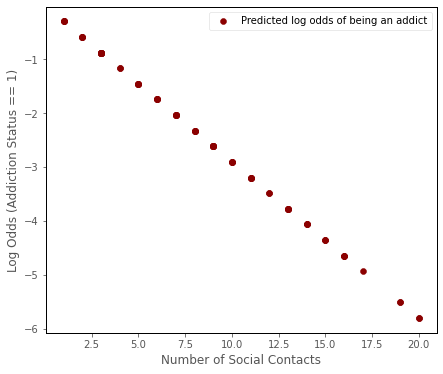

In [10]:
# the model predictions are linear on the log scale
log_odds_predictions_1 = mod.params.loc['Intercept'] +  mod.params.loc['number_of_social_contacts'] * df['number_of_social_contacts']
islands_GLM.addiction_plot(df, log_odds_predictions_1, log_scale = True)

To get the predictions on a probability scale (e.g. ranging between 0 and 1, we must convert from log odds to probability using the following formula:

$ \large \hat\pi_{1i} =  \frac{e^{\hat{y}_{i}}}{1 + e^{\hat{y_{i}}}}$ 

The probability prediuctions are shown on the graph below:

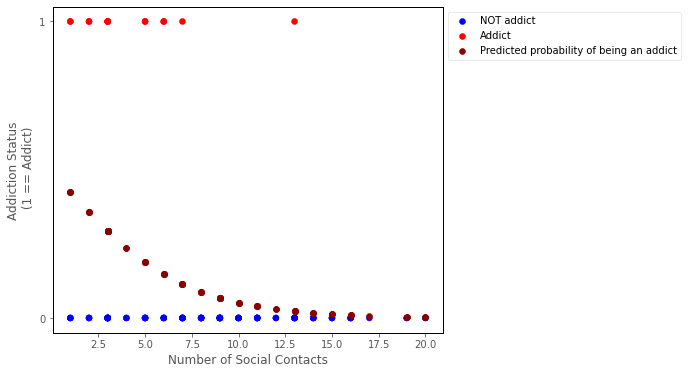

In [11]:
# this code generates the plot below
probability_predictions_1 = np.exp(log_odds_predictions_1)/(1 + np.exp(log_odds_predictions_1))
islands_GLM.addiction_plot(df, predictions = probability_predictions_1, plot_predictions = True)

We can also get the predcited probability of being the other outcome category (e.g. NOT an addict), by using the following formula:

$ \large \hat\pi_{0i} = 1 - \hat\pi_{1i} $

The graph below shows also the predcited probability of NOT being an addict:

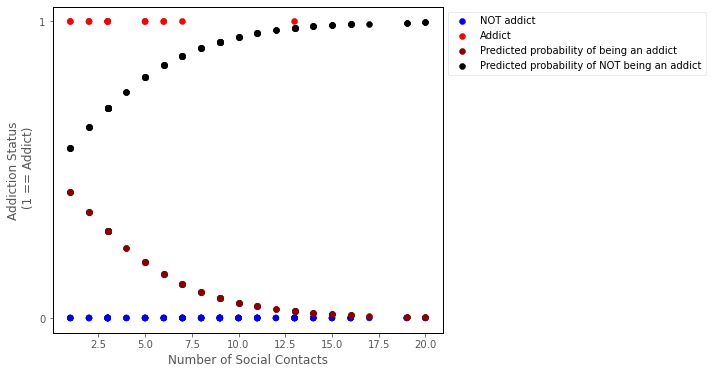

In [12]:
# this code generates the plot below
islands_GLM.addiction_plot(df, predictions = probability_predictions_1, plot_predictions = True, plot_other = True)

## Effect of the slope and intercept on the Logistic Regression curve

On the scale of the log odds ratio, changing the intercept moves the line up and down the y-axis. On the probability scale, this moves the logistic curve along the x-axis:

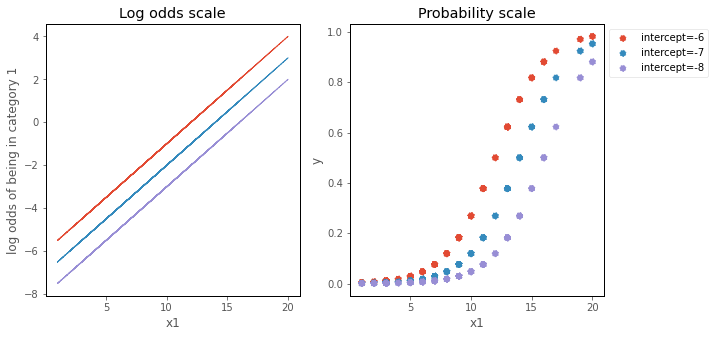

In [13]:
# this code generates the plot below
b0 = mod.params[0]
b1 = mod.params[1]
islands_GLM.odds_prob_intercept_plot(b0, 0.5, df)

On the scale of the log odds ratio, changing the slope changes the steepness of the line. On the probability scale, this makes the logistic curve ascend more or less steeply:

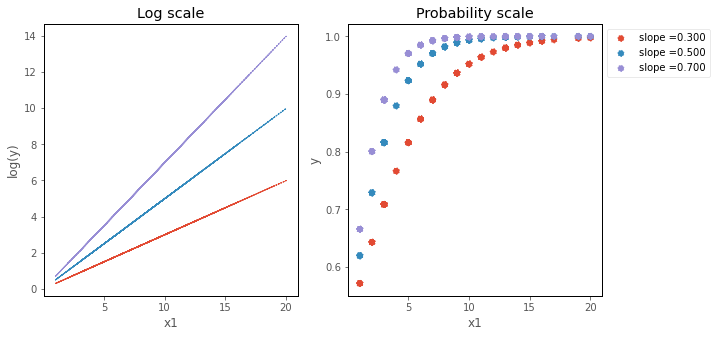

In [14]:
# this code generates the plot below
islands_GLM.odds_prob_slope_plot(b0, b1, df);

## Binary Logistic Regression with multiple predictors

For models with more than one predictor, binary logistic regression fits a surface to the data, if there are two predictions, and a manifold to the data if there are more than two predictors.

The graph below shows a binary logistic regression model fit to an outcome with two continuous predictor variables. The blue surface is the binary logistic regression model, the red dots and black dots are the hypothetical data points. The blue surface indicates the predicted probability of being in outcome category 1, for any set of predictor scores:

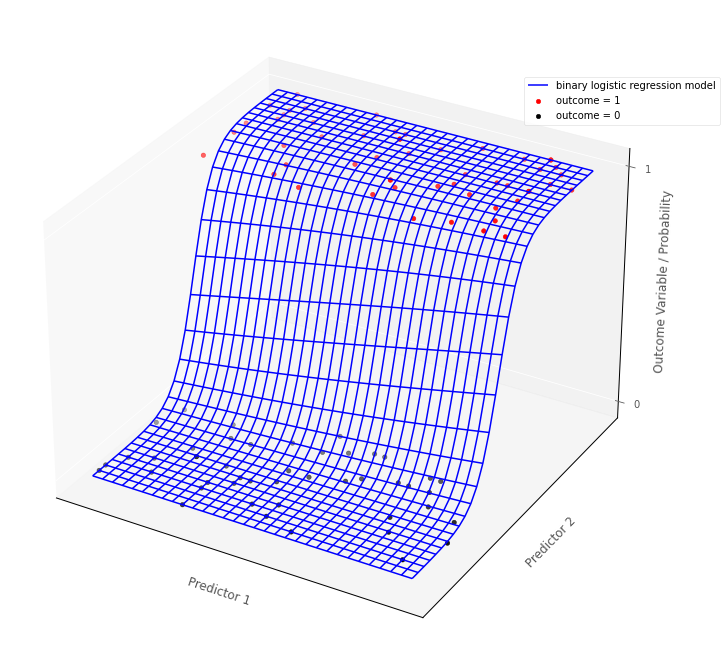

In [15]:
# show how binary logistic regression works in multiple dimensions
islands_GLM.bin_log_reg_plot()

The data from the island also contains a second binary categorical variable, detailed below:

`drug_alone`: a binary categorical variable, indicating whether a person uses their drug of choice alone at least twice a week (`1` indicates `YES`, `0` indicates `NO`)

We can us this as a second predictor, using the model: `addiction_status ~ number_of_social_contacts + drug_alone`.

We'll uses `statsmodels` to fit this model:

In [16]:
# fit a logistic regression model with statsmodels
mod2 = smf.logit('addiction_status ~ number_of_social_contacts + drug_alone', data = df).fit()

# show the regression table
mod2.summary()

Optimization terminated successfully.
         Current function value: 0.334882
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       addiction_status   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                  0.1731
Time:                        19:59:43   Log-Likelihood:                -33.488
converged:                       True   LL-Null:                       -40.496
Covariance Type:            nonrobust   LLR p-value:                 0.0009045
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.2666      0.643     -0.414      0.679      -1.528       0.994
number_of_social_contacts    -0.2891      0.096     -3.011      0.003      -0.477      -0.101
drug_alone                    0.4996      0.625      0.800      0.424      -0.725       1.724
=============================================================================================
"""

The graph below shows the raw data, and the logistic regression probability surface, in 3D dataspace:

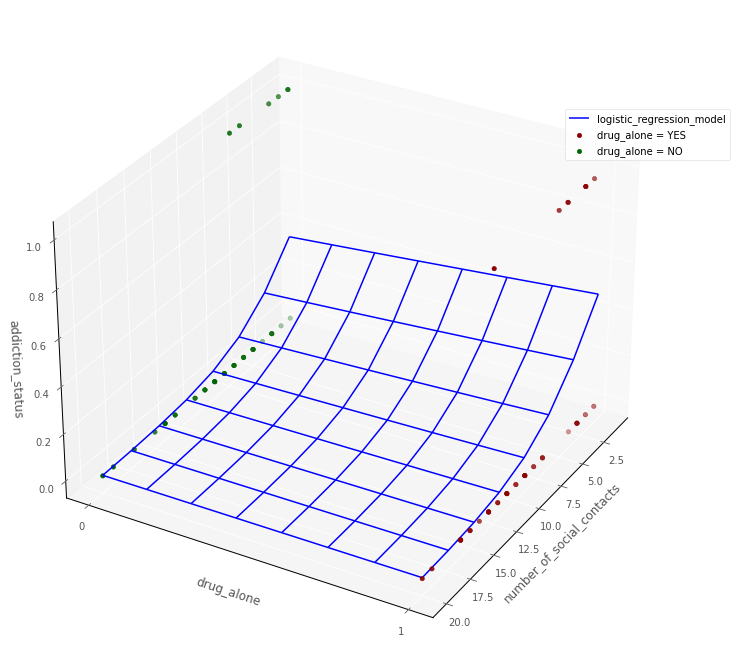

In [17]:
# this code generates the plot below
intercept, number_of_social_contacts_slope, drug_type_slope = mod2.params[:3]
islands_GLM.three_D_model_plot('number_of_social_contacts', 'drug_alone', 
                   'addiction_status', intercept, number_of_social_contacts_slope, drug_type_slope,
                  df, 'logistic_regression_model', 'drug_alone = YES', 'drug_alone = NO', azim = 30)

## Interpretation (multiple predictors)

Note: the intercept and slopes are shown under the `coef` heading in the regression table above, the associated $p$-values are shown under `P>|z|`.

The intercept, tells us the predicted log odds ratio of being in category 1, for an observation whose score on all other predictors is 0. The $p$-value for the intercept tells us how (un)likely it would be to obtain an intercpet of the value we obtained, if randomly sampling from a population where the true intercept was 0.

The slope of each predictor tells us the predicted difference in log odds ratio of being in category 1 when we compare between scores for two hypothetical observations which differed *only* by a one unit score in that predictor, controlling for the other variables in the model. The $p$-values for each predictor tell us how (un)likely it would be, under repeated random sampling, to observe a slope of the size we observed if the population slope was zero.

## Statistical interaction in Binary Logistic Regression

The definition of statistical interaction is: the influence of a predictor on the outcome variable depends on the value of some other predictor(s).

If we fit an interaction term in a binary logistic regression model, then this the logistic regression probability surface to 'bend', so that the effect of the predictors is not constant, but depends on the value of the other predictors. The graph below shows a logisitc probability surface with statistical interaction:

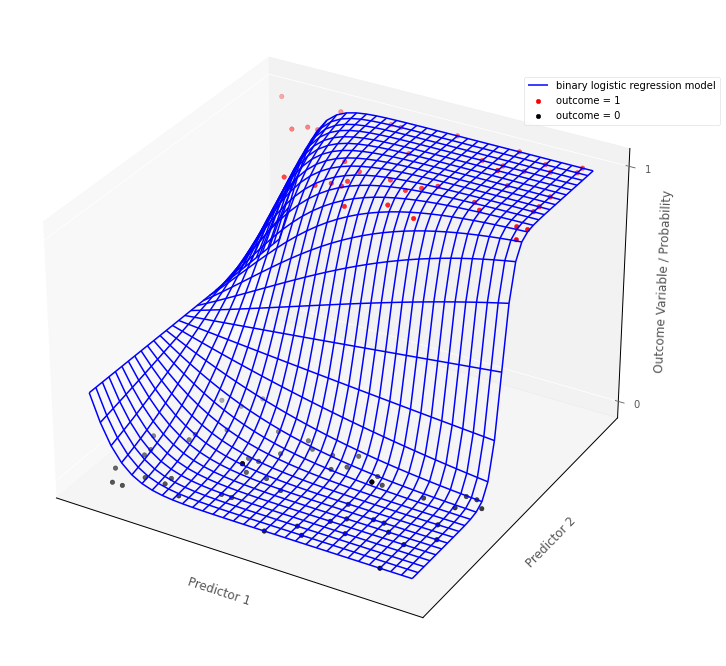

In [18]:
# this code generates the plot below
islands_GLM.bin_log_reg_plot(interaction = True)

That's it for binary logistic regression (for now). You can visit another page/island via the links in the table of contents, and at the bottom of this page...

***
By [pxr687](99_about_the_author.ipynb) 